In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy as scipy
import pyspark
import matplotlib as mpl
from sklearn import mixture
from sklearn import ensemble
from sklearn import cross_validation
from matplotlib.patches import Circle, Rectangle, Arc
from pyspark.ml.pipeline import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark import keyword_only
from pyspark.sql import SQLContext, Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType, LongType, DoubleType, StringType , FloatType
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.sql.types import IntegerType, LongType, DoubleType, StringType
from scipy.stats import ttest_ind
from sklearn.cross_validation import train_test_split
import pyspark
#from xgboost import XGBClassifier


In [8]:
sc = pyspark.SparkContext(master='local[*]')

In [9]:
sqlContext = SQLContext(sc)

In [10]:
/Users/IvanBabic/Big_Data_Course_UM/Proyecto_Final/Kobe/trabajoFinal

SyntaxError: invalid syntax (<ipython-input-10-eeee2f2ae393>, line 1)

In [14]:
path_to_file = '/home/jovyan/work/Proyecto_Final/Kobe/trabajoFinal/data.csv'

In [17]:
raw_data_rdd = sc.textFile(path_to_file).map(lambda x: [y.strip() for y in x.split(',')])

In [19]:
raw_data_rdd.take(2)

[[u'action_type',
  u'combined_shot_type',
  u'game_event_id',
  u'game_id',
  u'lat',
  u'loc_x',
  u'loc_y',
  u'lon',
  u'minutes_remaining',
  u'period',
  u'playoffs',
  u'season',
  u'seconds_remaining',
  u'shot_distance',
  u'shot_made_flag',
  u'shot_type',
  u'shot_zone_area',
  u'shot_zone_basic',
  u'shot_zone_range',
  u'team_id',
  u'team_name',
  u'game_date',
  u'matchup',
  u'opponent',
  u'shot_id'],
 [u'Jump Shot',
  u'Jump Shot',
  u'10',
  u'20000012',
  u'33.9723',
  u'167',
  u'72',
  u'-118.1028',
  u'10',
  u'1',
  u'0',
  u'2000-01',
  u'27',
  u'18',
  u'',
  u'2PT Field Goal',
  u'Right Side(R)',
  u'Mid-Range',
  u'16-24 ft.',
  u'1610612747',
  u'Los Angeles Lakers',
  u'2000-10-31',
  u'LAL @ POR',
  u'POR',
  u'1']]

[[u'action_type',0
  u'combined_shot_type',
  u'game_event_id',
  u'game_id',
  u'lat',4
  u'loc_x', 5 
  u'loc_y', 6
  u'lon',7
  u'minutes_remaining',
  u'period',
  u'playoffs',
  u'season',11
  u'seconds_remaining',12
  u'shot_distance',13
  u'shot_made_flag',
  u'shot_type',
  u'shot_zone_area',
  u'shot_zone_basic',
  u'shot_zone_range',
  u'team_id',19
  u'team_name',20
  u'game_date',21
  u'matchup',
  u'opponent',
  u'shot_id'],
 [u'Jump Shot',0
  u'Jump Shot',
  u'10',
  u'20000012',
  u'33.9723',
  u'167',
  u'72',
  u'-118.1028',7
  u'10',
  u'1',
  u'0',10
  u'2000-01',11
  u'27',
  u'18',13
  u'',
  u'2PT Field Goal',
  u'Right Side(R)',
  u'Mid-Range',
  u'16-24 ft.',18
  u'1610612747',
  u'Los Angeles Lakers',
  u'2000-10-31',21
  u'LAL @ POR', 22
  u'POR',
  u'1']]
  4 7 13 19 20 22

In [66]:
def local_trans(val):
    res = 1
    if '@' in val:
        res = 0
    return res

def xy_to_rad(x,y):
    rho = float(np.sqrt(x**2 + y**2))
    phi = float(np.arctan2(y, x))
    return [rho, phi]

In [69]:
header = raw_data_rdd.first()
header_use = header[:4] + header[5:7] + header[8:13] + header[14:19] + [header[21]] + header[23:] + ["local", 'distance', 'angle(radians)'] #borramos   4 7 13 19 20 22
print len(header_use)
raw_data_df = raw_data_rdd.filter(lambda row : (row != header) and (row[14] != '')).map(lambda x: [x[0],x[1],int(x[2]),int(x[3]),int(x[5]),int(x[6]),int(x[8]),int(x[9]),int(x[10]),x[11],int(x[12]),int(x[14]),x[15],x[16],x[17],x[18],x[21],x[23],x[24],local_trans(x[22])] + xy_to_rad(int(x[5]),int(x[6])) ).toDF(header_use)


22


In [52]:
raw_data_df.show()

+-----------------+------------------+-------------+--------+-----+-----+-----------------+------+--------+-------+-----------------+-------------+--------------+--------------+--------------------+--------------------+---------------+----------+-----+--------+-------+
|      action_type|combined_shot_type|game_event_id| game_id|loc_x|loc_y|minutes_remaining|period|playoffs| season|seconds_remaining|shot_distance|shot_made_flag|     shot_type|      shot_zone_area|     shot_zone_basic|shot_zone_range| game_date|local|opponent|shot_id|
+-----------------+------------------+-------------+--------+-----+-----+-----------------+------+--------+-------+-----------------+-------------+--------------+--------------+--------------------+--------------------+---------------+----------+-----+--------+-------+
|        Jump Shot|         Jump Shot|           12|20000012| -157|    0|               10|     1|       0|2000-01|               22|           15|             0|2PT Field Goal|        Left 

In [65]:
#%% cluster the shot attempts of kobe using GMM on their location

numGaussians = 13
gaussianMixtureModel = mixture.GMM(n_components=numGaussians, covariance_type='full', 
                                   params='wmc', init_params='wmc',
                                   random_state=1, n_init=3,  verbose=0)
gaussianMixtureModel.fit(kobe_Data_df_na_dropped.ix[:,['loc_x','loc_y']])

kobe_Data_df_na_dropped['shotLocationCluster'] = gaussianMixtureModel.predict(kobe_Data_df_na_dropped.ix[:,['loc_x','loc_y']])

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


El cluster se forma en base a la posicion de los tiros (ver si podemos meter los clusters que hiciste vos ivan aca) https://www.kaggle.com/selfishgene/psychology-of-a-professional-athlete

In [66]:

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

def Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages):
    
    fig, h = plt.subplots();
    for i, (mean, covarianceMatrix) in enumerate(zip(gaussianMixtureModel.means_, gaussianMixtureModel._get_covars())):
        # get the eigen vectors and eigen values of the covariance matrix
        v, w = np.linalg.eigh(covarianceMatrix)
        v = 2.5*np.sqrt(v) # go to units of standard deviation instead of variance
        
        # calculate the ellipse angle and two axis length and draw it
        u = w[0] / np.linalg.norm(w[0])    
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        currEllipse = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=ellipseColors[i])
        currEllipse.set_alpha(0.5)
        h.add_artist(currEllipse)
        h.text(mean[0]+7, mean[1]-1, ellipseTextMessages[i], fontsize=12)


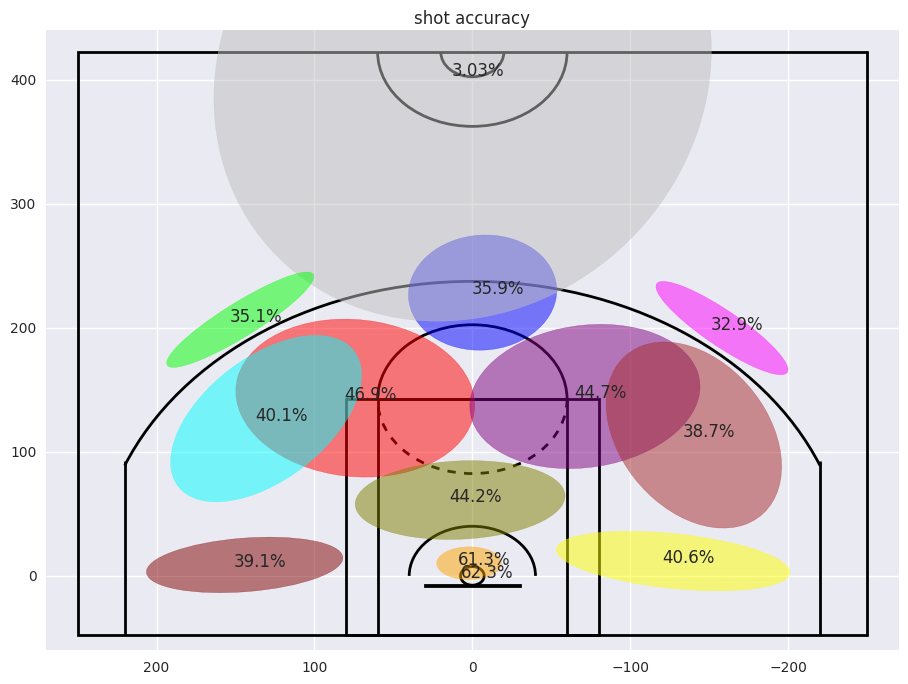

In [68]:
#%% for each cluster, calculate it's individual accuracy and plot it

plt.rcParams['figure.figsize'] = (11, 8)

variableCategories = kobe_Data_df_na_dropped['shotLocationCluster'].value_counts().index.tolist()

clusterAccuracy = {}
for category in variableCategories:
    shotsAttempted = np.array(kobe_Data_df_na_dropped['shotLocationCluster'] == category).sum()
    shotsMade = np.array(kobe_Data_df_na_dropped.ix[kobe_Data_df_na_dropped['shotLocationCluster'] == category,'shot_made_flag'] == 1).sum()
    clusterAccuracy[category] = float(shotsMade)/shotsAttempted
ellipseColors = ['red','green','purple','cyan','magenta','yellow','blue','orange','silver','maroon','lime','olive','brown','darkblue']
ellipseTextMessages = [str(100*clusterAccuracy[x])[:4]+'%' for x in range(numGaussians)]
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('shot accuracy')

Dado el resultado anterior, es evidente que la zona de la cancha de la que tire el jugador en cuestion es muy relevante (centro medio izquierda pintura) los clusters que se formaron matchean muy bien con la grafica de los tiros de al cancha que vimos antes. Las zonas mas densas de antes formaron sus propios clusters mientras que los tiros desde muy lejos formaron otros. 

Si miramos los features minutes_remaining y seconds_remaining lo cual es un poco extrano. Analizando el data quality report vemos que el maximo de minutos es 11 y el de segundos 59 por lo que podemos entender que remaining_feature significa la cantidad de minutos que faltan para terminar el cuarto y seconds_remaining, la cantidad de segundos dentro de ese minuto que faltan. Tenemos un feature el cual es period que nos dice en que cuarto es que sucede el tiro. A medida que pasan los cuartos, el cansancio es mayor y por eso es importante mantener este feature para que refleje ese posible cansancio.

Llevemos esos dos features a uno solo que sea la cantidad de segundos del cuarto que faltan para terminar el cuarto.

In [ ]:
kobe_Data_df_na_some_columns_dropped['remaining_time_quarter(seconds)'] = kobe_Data_df_na_some_columns_dropped['minutes_remaining'] * 60 + kobe_Data_df_na_some_columns_dropped['seconds_remaining']

In [ ]:
kobe_Data_df_na_some_columns_dropped = kobe_Data_df_na_some_columns_dropped.drop('minutes_remaining', 1)
kobe_Data_df_na_some_columns_dropped = kobe_Data_df_na_some_columns_dropped.drop('seconds_remaining', 1)

A su vez, si analizamos los features matchup y opponent vemos que lo que en realidad nos interesa es si esta jugando de local o visitante y el oponente por lo tanto vamos a transformar matchup a una columna que es 1 si esta jugando de visitante y 0 si esta jugando de local

In [ ]:
class matchUpTransformer(Transformer, HasInputCol, HasOutputCol): 
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(matchUpTransformer, self).__init__()
        kwargs = self.__init__._input_kwargs
        self.setParams(**kwargs)
        
    @keyword_only 
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self.setParams._input_kwargs
        return self._set(**kwargs)
        
    def _transform(self, dataset):
        in_col = dataset[self.getInputCol()]
        out_col = self.getOutputCol()
        udf = UserDefinedFunction(lambda x: clean_value_Match_Up(x),IntegerType())
        return dataset.withColumn(out_col, udf(in_col))

def clean_value_Match_Up(in_value):
    if (in_value):
        if "@" in in_value.strip():
            return 1
        else:
            return 0
    else:
        return 'error missing value not expected'

In [ ]:
match_up_transformer = matchUpTransformer(inputCol='matchup', outputCol='matchup_transformer')

In [ ]:
kobe_Data_df_na_some_columns_dropped = match_up_transformer.transform(kobe_Data_df_na_some_columns_dropped)

In [ ]:
kobe_Data_df_na_some_columns_dropped

El feature playoff tambien es relevante dado que generalmente en los play

En un principio, el feature shot_zone_basic lo vamos a dejar porque mas alla de que tenemos la distancia y angulo al aro, estas zonas pueden marcale al modelo informacion relevante porque podria juntar los tiros dentro de mid-range, por ejemplo, en un rango de distancias. Despues le sacaremos esta variable para ver si mejora el arbol. Tambien, creemos que con el resultado del clustering y este dato tambien tienen mucho en comun lo que nos da otra razon para eliminarlo.

En cambio, la variable shot_zone_range no parece util porque como marca el grafico son medios anillos concentricos con el aro, que dadas las coordenadas polares no parecen aportar informacion.

(hacer graficas de ambos para explicar)

In [ ]:
import matplotlib.cm as cm
plt.figure(figsize=(20,10))

def scatter_plot_by_category(dataframe, feature):
    alpha = 0.1
    groups = dataframe.groupby(feature)
    cs = cm.rainbow(np.linspace(0, 1, len(groups)))
    for g, c in zip(groups, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)

# shot_zone_area
plt.subplot(131)
scatter_plot_by_category(kobe_Data_df_na_some_columns_dropped, 'shot_zone_area')
plt.title('shot_zone_area')

# shot_zone_basic
plt.subplot(132)
scatter_plot_by_category(kobe_Data_df_na_some_columns_dropped, 'shot_zone_basic')
plt.title('shot_zone_basic')

# shot_zone_range
plt.subplot(133)
scatter_plot_by_category(kobe_Data_df_na_some_columns_dropped, 'shot_zone_range')
plt.title('shot_zone_range')

In [ ]:
kobe_Data_df_na_some_columns_dropped.head()


In [ ]:
kobe_Data_df_na_some_columns_dropped.describe(include=['O'])

In [ ]:
cols_categoric = [ "action_type", "combined_shot_type", "season", "shot_type", "shot_zone_area", "shot_zone_basic", "shot_zone_range", "game_date", "matchup", "opponent"]
df_dummies = pd.get_dummies(columns=cols_categoric)
kobe_Data_with_idx = kobe_Data_df_na_some_columns_dropped.join(df_dummies, how='outer')

In [ ]:
cat_columns = kobe_Data_df_na_some_columns_dropped.select_dtypes(['O']).columns
kobe_Data_df_na_some_columns_dropped[cat_columns] = kobe_Data_df_na_some_columns_dropped[cat_columns].astype('category')
kobe_Data_df_na_some_columns_dropped[cat_columns] = kobe_Data_df_na_some_columns_dropped[cat_columns].apply(lambda x: x.cat.codes)

In [ ]:
kobe_Data_df_na_some_columns_dropped.select_dtypes(['O']).columns